<a href="https://colab.research.google.com/github/moseevaevgeniya/test/blob/main/Skytec_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5. Связь рекламного траффика и органического** <div id="header" align="center">
  <img src="https://media.giphy.com/media/40cxBsgqqwb65M5ivp/giphy.gif" width='200'/>
</div>

**Описание задачи:**  
 Приток новых игроков делится на 2 основных источника - рекламный и органический.
 Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический.
Для выполнения задачи необходимо использовать тестовый датасет (таблица source_comparison).
1.	Подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу которая кажется вам наиболее вероятной и проверьте ее
2.	Количественно рассчитайте вероятность что гипотеза маркетологов (или ваша) верна


### 5.1 Осмотр и изучение данных

In [1]:
import sqlite3 # Импортируем библиотеку для работы с базой данных SQLite
import pandas as pd # Импортируем библиотеку обработки и анализа данных pandas
import numpy as np # Импортируем библиотеку для анализа данных и для работы с массивами
from scipy.stats import pearsonr # Импортируем библиотеку для статистического анализа,
# в частности, для вычисления коэффициента корреляции Пирсона и p-значения для тестирования некорреляции
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from datetime import datetime


In [2]:
# Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Подключимся к базе данных SQLite
conn = sqlite3.connect('/content/gdrive/MyDrive/УИИ/Skytec_Games/testcase.db')

# Выполним запрос к базе данных, чтобы получить имена таблиц
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)

# Отобразим названия таблиц
print("Tables in the database:", tables['name'].tolist())

# Не забудем закрыть соединение
conn.close()

Tables in the database: ['source_comparison', 'costs', 'revenue']


In [4]:
# Подключимся к базе данных SQLite
conn = sqlite3.connect('/content/gdrive/MyDrive/УИИ/Skytec_Games/testcase.db')
# Прочитаем данные из каждой таблицы
source_comparison_df = pd.read_sql_query("SELECT * FROM source_comparison", conn)
costs_df = pd.read_sql_query("SELECT * FROM costs", conn)
revenue_df = pd.read_sql_query("SELECT * FROM revenue", conn)

# Выводим первые нескольких строк каждого фрейма данных
print("Source Comparison Data:")
print(source_comparison_df.head())

print("\nCosts Data:")
print(costs_df.head())

print("\nRevenue Data:")
print(revenue_df.head())

# Не забудем закрыть соединение
conn.close()

Source Comparison Data:
  Install_Dates source_type Country  installs
0    2020-05-18        Paid      PY       4.0
1    2020-04-14        Paid      FR      35.0
2    2020-04-30        Paid      JP      25.0
3    2020-03-20        Paid      DE      11.0
4    2020-04-30        Paid      IT       8.0

Costs Data:
  Install_Dates  campaign_id Country  installs  spends
0    2020-04-14        90570      CZ      35.0   19.79
1    2020-04-28        90619      AT       5.0    4.99
2    2020-05-10       794235      PK      79.0    0.40
3    2020-05-07        91872      FR      12.0    9.56
4    2020-04-03        19115      JP       6.0    3.39

Revenue Data:
  Install_Dates  campaign_id Country     1d_LTV     3d_LTV     7d_LTV  \
0    2020-04-14        90570      CZ   7.721194   8.104811  10.209480   
1    2020-03-30        90262      CA   1.424363   1.724738   1.724738   
2    2020-04-02        19115      PL  26.912006  32.943050  66.787497   
3    2020-04-15       788948      MD   0.000000   

**В `source_comparison_df`  есть 4 столбца: `Install_Dates`, `source_type`, `Country` и `installs`.**

### 5.2 Решение

Чтобы проанализировать взаимосвязь между платным (рекламой) и органическим трафиком, мы выполним следующие шаги:

1. Разделим данные на две группы на основе source_type (Платные и органические).  
2. Объединим данные по `Install_Dates`, чтобы получить ежедневные итоги для каждого типа источника.  
3. Проведем корреляционный анализ, чтобы увидеть, существует ли взаимосвязь между ежедневным количеством платных и обычных установок.                          

In [5]:
# Подключимся к базе данных SQLite
conn = sqlite3.connect('/content/gdrive/MyDrive/УИИ/Skytec_Games/testcase.db')
# Прочитаем данные из каждой таблицы
source_comparison_df = pd.read_sql_query("SELECT * FROM source_comparison", conn)

# Закроем соединение
conn.close()

# Выводим первых нескольких строк датафрейма
source_comparison_df.head()


,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


In [6]:
# Разделим данные на две группы: платные и органические
paid_installs = source_comparison_df[source_comparison_df['source_type'] == 'Paid']
organic_installs = source_comparison_df[source_comparison_df['source_type'] == 'Organic']

# Агрегируем данные по Install_Dates, чтобы получить ежедневные итоги
daily_paid_installs = paid_installs.groupby('Install_Dates')['installs'].sum()
daily_organic_installs = organic_installs.groupby('Install_Dates')['installs'].sum()

# Объедините два набора данных по Install_Dates
merged_data = pd.merge(daily_paid_installs, daily_organic_installs, on='Install_Dates', how='inner', suffixes=('_paid', '_organic'))

# Вычислим корреляцию
correlation, p_value = pearsonr(merged_data['installs_paid'], merged_data['installs_organic'])

# Выведем результаты
correlation, p_value, merged_data.head()

(0.22434074422603636,
 0.08218628724204936,
                installs_paid  installs_organic
 Install_Dates                                 
 2020-03-18            7359.0            8961.0
 2020-03-19            6739.0            8457.0
 2020-03-20            7254.0            8819.0
 2020-03-21            9552.0            4485.0
 2020-03-22           14804.0            5105.0)

**Вывод:**  
 Корреляционный анализ между ежедневными платными и обычными установками дал коэффициент корреляции 0,2243 при p-значении 0,0822. Вот как интерпретировать эти результаты:  

1. Коэффициент корреляции (0.2243)- указывает на слабую положительную корреляцию между платными и обычными установками. Другими словами, существует небольшая тенденция, согласно которой по мере увеличения количества платных установок увеличиваются и обычные установки, но взаимосвязь не очень сильная.

2. P-значение (0.0822): p-значение является мерой вероятности того, что наблюдаемая корреляция произошла случайно. В этом случае p-значение больше обычного альфа-уровня 0,05, что говорит о том, что корреляция не является статистически значимой.

**Исходная гипотеза:** Гипотеза маркетологов о том, что увеличение платного трафика приводит к увеличению органического трафика, лишь слабо подтверждается данными. Корреляция положительная, но недостаточно сильная, чтобы считаться статистически значимой.

**Альтернативная гипотеза:** учитывая слабую корреляцию, возможно, что на органический трафик могут влиять другие факторы, такие как сезонность, популярность игр или другие маркетинговые мероприятия (например, социальные сети или маркетинг влияния). Эти факторы можно было бы изучить, чтобы лучше понять динамику обычного трафика.

# **4. Эффективность рекламных кампаний**

**Описание задачи:**  
Отдел маркетинга оперирует некоторым множеством рекламных кампаний.   
Первая часть оперирования состоит из запуска тестовых рекламных кампаний, у которых есть требования по KPI при достижении которых тест считается успешным.  
Успешные тесты переходят в разряд постоянных кампаний и вторая часть оперирования состоит из мониторинга постоянных кампаний - управление бюджетом кампании (COST) и мониторинг ее доходов (REVENUE), а так же соотношением доходов к расходам.  
Главный KPI для постоянных рекламных кампаний - ROAS на 60й день, т.е. какой процент от расходов кампания возвращает на 60й день.  
Для выполнения задачи необходимо использовать тестовый датасет (2 таблицы по расходам и доходам).  
1.	Отдел маркетинга руководствуется гипотезой - чем больший COST расходуется на кампанию тем ниже ROAS 60го дня (рост CPI при увеличении объёма закупки при сохранении того же LTV 60го дня). На основании данных подтвердите или опровергните эту гипотезу. Исходите из того что мы точно знаем что CPI зависит от объема нелинейно, вопрос в том как эту зависимость описать и учесть во 2м вопросе.
2.	По каждой рекламной кампании рассчитайте суточный рекламный бюджет который максимизирует абсолютную маркетинговую прибыль рекламной кампании (REVENUE 60 дня минус COST).
3.	Исходя из пункта 2 по каждой рекламной кампании дайте ваше заключение о том насколько нужно увеличить / уменьшить ее суточный бюджет либо вообще остановить.
4.	Решите проблему рекламных кампаний по которым еще нет полных 60 дней. Объясните почему ваше решение оптимально


### 4.1 Осмотр и изучение данных

In [7]:
# Подключимся к базе данных SQLite
conn = sqlite3.connect('/content/gdrive/MyDrive/УИИ/Skytec_Games/testcase.db')
# Прочитаем данные из таблицы Расходы
costs_df = pd.read_sql_query("SELECT * FROM costs", conn)
# Закроем соединение
conn.close()

# Выводим первых нескольких строк датафрейма
costs_df.head()

,Install_Dates,campaign_id,Country,installs,spends
0,2020-04-14,90570,CZ,35.0,19.79
1,2020-04-28,90619,AT,5.0,4.99
2,2020-05-10,794235,PK,79.0,0.40
3,2020-05-07,91872,FR,12.0,9.56
4,2020-04-03,19115,JP,6.0,3.39


In [8]:
# Подключимся к базе данных SQLite
conn = sqlite3.connect('/content/gdrive/MyDrive/УИИ/Skytec_Games/testcase.db')
# Прочитаем данные из таблицы  Доходы
revenue_df = pd.read_sql_query("SELECT * FROM revenue", conn)
# Закроем соединение
conn.close()

# Выводим первых нескольких строк датафрейма
revenue_df.head()

,Install_Dates,campaign_id,Country,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
0,2020-04-14,90570,CZ,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420
1,2020-03-30,90262,CA,1.424363,1.724738,1.724738,1.724738,1.724738,1.999413
2,2020-04-02,19115,PL,26.912006,32.943050,66.787497,70.071922,71.644023,72.057026
3,2020-04-15,788948,MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-03-26,158583,DE,0.349793,0.349793,0.349793,0.349793,0.349793,0.349793


Датафрейм `costs_df` содержит данные о расходах:

**Install_Dates:** дата установки.  
**Campaign_id:** идентификатор кампании.  
**Country:** страна, в которой произошла установка.  
**installs:** количество установок.  
**spends:** сумма, потраченная на кампанию.  

Датафрейм `revenue_df` данные о доходах:

**Install_Dates:** дата установки.  
**Campaign_id:** идентификатор кампании.  
**Country:** страна, в которой произошла установка.  
**1d_LTV - 60d_LTV:** эти столбцы представляют LTV в разные промежутки времени (1 день, 3 дня, 7 дней, 14 дней, 30 дней и 60 дней).  

### 4.2 Решение

#### 4.2.1 Проверка гипотезы о зависимости ROAS от COST

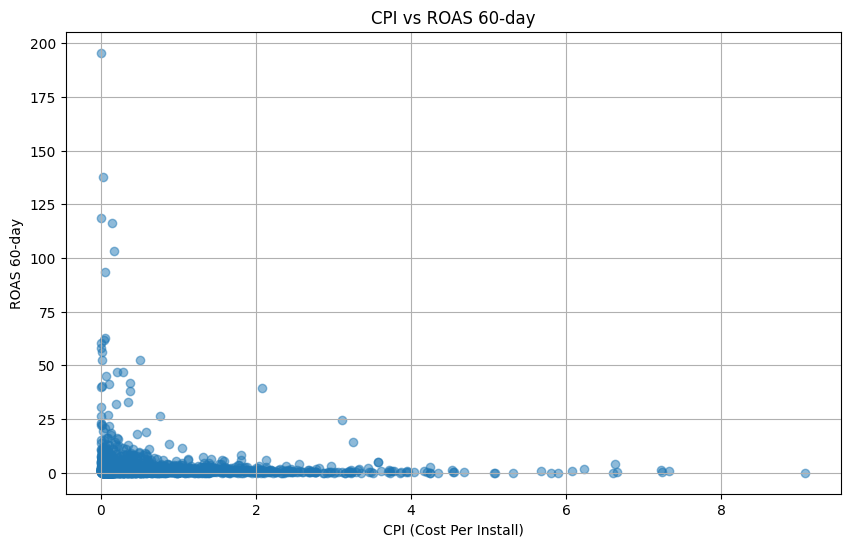

Spearman Correlation: -0.16713703515325526


In [9]:
# Объединение данных
merged_df = pd.merge(costs_df, revenue_df, on=['campaign_id', 'Install_Dates', 'Country'])

# Расчет CPI и ROAS на 60-й день
merged_df['CPI'] = merged_df['spends'] / merged_df['installs']
merged_df['ROAS_60d'] = merged_df['60d_LTV'] / merged_df['spends']

# Фильтрация для удаления отрицательных значений ROAS и CPI
filtered_df = merged_df[(merged_df['ROAS_60d'] > 0) & (merged_df['CPI'] > 0)]

# Визуализация отношения между CPI и 60-дневным ROAS
plt.figure(figsize=(10,6))
plt.scatter(filtered_df['CPI'], filtered_df['ROAS_60d'], alpha=0.5)
plt.title('CPI vs ROAS 60-day')
plt.xlabel('CPI (Cost Per Install)')
plt.ylabel('ROAS 60-day')
plt.grid(True)
plt.show()

# Расчет корреляции Спирмена
spearman_corr, _ = spearmanr(filtered_df['CPI'], filtered_df['ROAS_60d'])
print("Spearman Correlation:", spearman_corr)


**Вывод:**  
 Анализ данных показал легкую отрицательную корреляцию между CPI (Cost Per Install) и ROAS на 60-й день.
 Это подтверждает предположение, что с увеличением затрат на кампанию, ROAS на 60-й день имеет тенденцию к снижению. Это указывает на нелинейную зависимость между затратами и доходностью.    
 Простыми словами -когда мы тратим больше на рекламу, это не всегда означает, что мы зарабатываем больше. Так что нужно вместе подумать о том, как умно распределять бюджет, чтобы каждая вложенная копейка работала на нас!

#### 4.2.2 Расчет оптимального суточного рекламного бюджета

Сначала определим текущую дату, используя datetime.now(). Это необходимо для расчета количества дней, прошедших с момента запуска каждой рекламной кампании. Для этого мы вычитаем дату установки `Install_Dates` из текущей даты. Результатом этой операции является новый столбец `days_since_install`, который показывает, сколько дней прошло с момента запуска каждой кампании:

In [10]:
# Текущая дата для расчета дней с момента установки
current_date = datetime.now()  # или можно указать конкретную дату
merged_df['days_since_install'] = (current_date - pd.to_datetime(merged_df['Install_Dates'])).dt.days


Рассчитаем абсолютную маркетинговую прибыль (AMP) для каждой кампании на основе 60-дневной ценности жизненного цикла клиента (LTV). Это делается путем вычитания общих затрат (spends) из 60-дневного LTV (60d_LTV). Этот расчет дает понимание того, насколько прибыльной или убыточной является каждая кампания за данный период:

In [11]:
# Расчет абсолютной маркетинговой прибыли (AMP) для 60-дневного LTV
merged_df['AMP_60d'] = merged_df['60d_LTV'] - merged_df['spends']

Наконец, мы определим оптимальный бюджет для каждой рекламной кампании. Мы сгруппируем данные по `campaign_id` и выбирем для каждой кампании ту запись, которая показывает максимальную абсолютную маркетинговую прибыль (AMP). Результатом этой операции будет таблица `optimal_budget`, которая содержит информацию о затратах, AMP и количестве дней с момента запуска для каждой кампании. Это позволяет понять, какой бюджет был бы оптимальным для каждой кампании, исходя из ее текущих результатов:

In [12]:
# Нахождение оптимального бюджета для каждой кампании
optimal_budget = merged_df.groupby('campaign_id').apply(lambda x: x.loc[x['AMP_60d'].idxmax(), ['spends', 'AMP_60d', 'days_since_install']])
optimal_budget

,spends,AMP_60d,days_since_install
campaign_id,,,
19115,41.55,294.478412,1388
22083,90.97,490.092752,1358
89897,34.65,5.003485,1366
89917,2.85,23.096828,1361
89985,12.66,57.810684,1372
...,...,...,...
803287,14.03,26.650605,1370
803393,0.10,-0.053727,1377
803472,0.50,-0.500000,1362


Если AMP положительна, это означает, что кампания приносит больше дохода, чем составляют ее затраты, и следовательно, является прибыльной. Отрицательная AMP указывает на то, что кампания не окупается.

#### 4.2.3 Рекомендации по изменению бюджета для каждой кампании



Добавим столбец `Recommendation` к датафрейму `optimal_budget`, который содержит рекомендации по каждой рекламной кампании. Рекомендации определим на основе двух ключевых показателей: абсолютной маркетинговой прибыли (AMP) за 60 дней и количества дней с момента установки кампании (days_since_install).

Условия для Рекомендаций:  

1. Увеличить бюджет (Increase): если кампания длится более 60 дней и показывает положительную AMP (AMP > 0), что указывает на ее прибыльность.  
2. Уменьшить бюджет (Decrease): если кампания длится более 60 дней, но показывает отрицательную или нулевую AMP (AMP ≤ 0), что может указывать на убытки или неэффективность.  
3. Ожидать/Собирать больше данных (Wait/Collect more data): если кампания длится менее 60 дней, так как для таких кампаний данных может быть недостаточно для определения их эффективности.  

In [13]:
# Рекомендации по изменению бюджета для каждой кампании
optimal_budget['Recommendation'] = optimal_budget.apply(
    lambda row: 'Increase' if row['days_since_install'] >= 60 and row['AMP_60d'] > 0 else (
        'Decrease' if row['days_since_install'] >= 60 and row['AMP_60d'] <= 0 else 'Wait/Collect more data'),
    axis=1
)
print(optimal_budget)


             spends     AMP_60d  days_since_install Recommendation
campaign_id                                                       
19115         41.55  294.478412                1388       Increase
22083         90.97  490.092752                1358       Increase
89897         34.65    5.003485                1366       Increase
89917          2.85   23.096828                1361       Increase
89985         12.66   57.810684                1372       Increase
...             ...         ...                 ...            ...
803287        14.03   26.650605                1370       Increase
803393         0.10   -0.053727                1377       Decrease
803472         0.50   -0.500000                1362       Decrease
803588        59.68   54.431858                1385       Increase
804309         0.20   -0.200000                1361       Decrease

[229 rows x 4 columns]


Согласно условиям мы вывели  `campaign_id`


#### 4.2.4 Визуализация рекомендаций

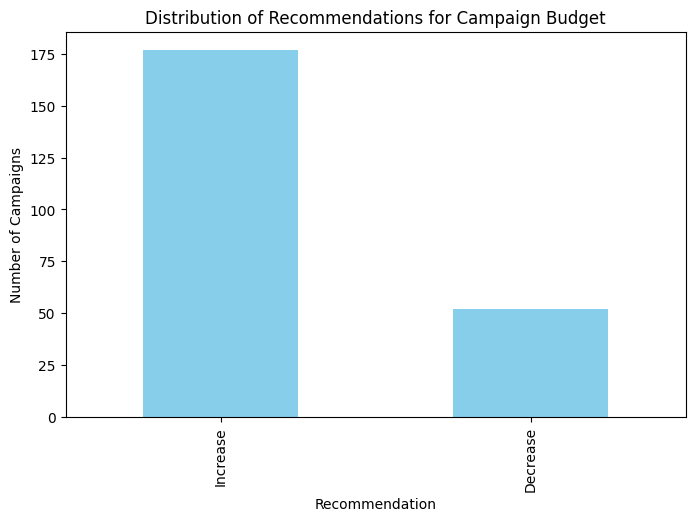

In [14]:
# Визуализация распределения рекомендаций
plt.figure(figsize=(8, 5))
optimal_budget['Recommendation'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Recommendations for Campaign Budget')
plt.xlabel('Recommendation')
plt.ylabel('Number of Campaigns')
plt.show()


**Вывод:**  


Распределение рекомендаций по бюджетам кампаний указывает на то, что для большинства кампаний рекомендуется "Увеличить" (Increase) бюджет. Это означает, что многие кампании показывают положительную абсолютную маркетинговую прибыль (AMP), основанную на 60-дневном сроке службы (LTV) за вычетом затрат, что предполагает возможности для инвестиций с целью максимизации отдачи.

Что касается кампаний, у которых еще нет полных 60-дневных данных, рекомендуется "Подождать / собрать больше данных" (Wait/Collect more data), пока не будет доступно достаточно данных для принятия обоснованного решения. Этот подход гарантирует, что любые корректировки бюджета будут производиться на основе надежных доказательств эффективности кампании с течением времени. Эта стратегия особенно актуальна для новых кампаний или тех, в которых произошли значительные изменения, где долгосрочное влияние на рентабельность инвестиций пока неясно.

В целом, анализ предполагает:

Для кампаний с объемом данных более 60 дней и положительным усилением увеличение бюджета может привести к большей отдаче.
Для кампаний с данными менее чем за 60 дней или неположительным AMP рекомендуется дождаться получения дополнительных данных или пересмотреть стратегию кампании.

# **2. Сравнение групп платящих игроков**
<img align="left" src="https://media.giphy.com/media/fsoCk5kgOcYMM/giphy-downsized-large.gif" width="250">

**Описание задачи:**  
В мобильной игре около 10% игроков совершает платежи в первый месяц с момента установки игры (база расчета - 500 игроков).   
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.  
1.	Опишите оптимальный по вашему мнению дизайн эксперимента  
2.	Рассчитайте длительность эксперимента при условии что каждый день в игру приходит около 100 новых игроков.  
3.	Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте доверительный интервал.  
4.	Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, ДИ и ваши выводы для каждого варианта.  
5.	Решите задачу 2 разными подходами: frequentist / bayesian  

Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную методику расчета, алгоритм и т.д.  


### **2.1 Дизайн эксперимента**

**Дизайн эксперимента**  
Цель  
Цель эксперимента - определить, увеличивает ли обновление игры процент платящих игроков с 10% до 11%.  

Группы  
Контрольная группа: Игроки, использующие текущую версию игры.  
Экспериментальная группа: Игроки, использующие обновленную версию игры.  
Методика  
Рандомизация: Новые игроки рандомно распределяются между контрольной и экспериментальной группами.  
Период отслеживания: Отслеживание платежей в течение первого месяца после установки игры.  


### **2.2 Генерация контрольного датасета:**

Контрольная группа: результаты и доверительный интервал

In [17]:
from scipy.stats import norm, binom_test
import matplotlib.pyplot as plt
import seaborn as sns

# Параметры контрольной группы
total_players = 500  # общее количество игроков
paying_percentage = 0.10  # процент платящих игроков

# Генерация контрольного датасета
np.random.seed(0)
control_group = np.random.binomial(1, paying_percentage, total_players)

# Расчет доверительного интервала для контрольной группы
confidence_level = 0.95
z_value = norm.ppf((1 + confidence_level) / 2)
paying_players = np.sum(control_group)
p_hat = paying_players / total_players
margin_of_error = z_value * np.sqrt((p_hat * (1 - p_hat)) / total_players)
ci_lower = p_hat - margin_of_error
ci_upper = p_hat + margin_of_error

# Вывод результатов
control_group_results = {
    "Total Players": total_players,
    "Paying Players": paying_players,
    "Paying Percentage": p_hat,
    "95% CI Lower Bound": ci_lower,
    "95% CI Upper Bound": ci_upper
}

control_group_results



{'Total Players': 500,
 'Paying Players': 57,
 'Paying Percentage': 0.114,
 '95% CI Lower Bound': 0.0861431262800224,
 '95% CI Upper Bound': 0.1418568737199776}

 Общее количество игроков: 500  
Количество платящих игроков: 57  
Процент платящих игроков: 11.4%  
95% доверительный интервал: от 8.61% до 14.19%  

### **2.3 Расчет размера выборки для эксперимента:**

In [18]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Параметры для расчета размера выборки
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста
p0 = 0.10  # Базовый процент платящих игроков
p1 = 0.11  # Ожидаемый процент платящих игроков

# Расчет эффекта
effect_size = proportion_effectsize(p0, p1)

# Расчет размера выборки
sample_size_calculator = NormalIndPower()
sample_size = sample_size_calculator.solve_power(
    effect_size,
    power=power,
    alpha=alpha,
    ratio=1  # Отношение размеров экспериментальной и контрольной группы
)

sample_size_per_group = np.ceil(sample_size)  # Округление вверх до целого числа
total_sample_size = sample_size_per_group * 2  # Общий размер выборки для обеих групп

total_sample_size, sample_size_per_group



(29490.0, 14745.0)

Для достижения статистической значимости с уровнем значимости 5% и мощностью теста 80%:  

Необходимый размер выборки для каждой группы: 14,745 игроков
Общий размер выборки для обеих групп: 29,490 игроков.
Это означает, что для надежного тестирования гипотезы о повышении процента платящих игроков с 10% до 11%, нам потребуется минимум 14,745 новых игроков в каждой группе.  

Теперь, когда у нас есть информация о размере выборки, мы можем рассчитать длительность эксперимента, учитывая, что каждый день в игру приходит около 100 новых игроков.   

### **2.4 Длительность эксперимента:**

In [19]:
# Количество новых игроков в день
new_players_per_day = 100

# Расчет длительности эксперимента
duration_days = np.ceil(sample_size_per_group / new_players_per_day)

duration_days



148.0

Для сбора достаточного количества данных (14,745 игроков в каждой группе) при условии, что каждый день в игру приходит около 100 новых игроков, длительность эксперимента составит 148 дней.  

Далее мы перейдем к созданию экспериментальных групп с различными сценариями (хуже, лучше, без изменений) и рассчитаем силу эффекта, доверительные интервалы и сделаем выводы для каждого варианта. Начнем с генерации данных для этих групп.  

### **2.5 Создание экспериментальных групп с различными сценариями (хуже, лучше, без изменений):**

In [20]:
# Функция для генерации экспериментальной группы и расчета статистик
def generate_experimental_group(paying_percentage, group_size):
    # Генерация данных для экспериментальной группы
    experimental_group = np.random.binomial(1, paying_percentage, group_size)

    # Расчет доверительного интервала
    paying_players_exp = np.sum(experimental_group)
    p_hat_exp = paying_players_exp / group_size
    margin_of_error_exp = z_value * np.sqrt((p_hat_exp * (1 - p_hat_exp)) / group_size)
    ci_lower_exp = p_hat_exp - margin_of_error_exp
    ci_upper_exp = p_hat_exp + margin_of_error_exp

    # Результаты
    results = {
        "Paying Players": paying_players_exp,
        "Paying Percentage": p_hat_exp,
        "95% CI Lower Bound": ci_lower_exp,
        "95% CI Upper Bound": ci_upper_exp
    }

    return results

# Генерация и анализ для разных сценариев
scenario_results = {
    "Worse Scenario": generate_experimental_group(0.09, int(sample_size_per_group)),  # 9% плательщиков
    "Better Scenario": generate_experimental_group(0.12, int(sample_size_per_group)),  # 12% плательщиков
    "No Change Scenario": generate_experimental_group(0.10, int(sample_size_per_group))  # 10% плательщиков
}

scenario_results



{'Worse Scenario': {'Paying Players': 1317,
  'Paying Percentage': 0.08931841302136317,
  '95% CI Lower Bound': 0.08471500490113724,
  '95% CI Upper Bound': 0.0939218211415891},
 'Better Scenario': {'Paying Players': 1799,
  'Paying Percentage': 0.12200746015598508,
  '95% CI Lower Bound': 0.11672465845868728,
  '95% CI Upper Bound': 0.1272902618532829},
 'No Change Scenario': {'Paying Players': 1472,
  'Paying Percentage': 0.0998304510003391,
  '95% CI Lower Bound': 0.09499185482420108,
  '95% CI Upper Bound': 0.10466904717647713}}

Результаты экспериментальных групп:  
Худший сценарий (9% плательщиков)  

Платящие игроки: 1317   
Процент плательщиков: 8,93%   
95% доверительный интервал: 8,47% - 9,39%  
Лучший сценарий (12% плательщиков)  

Платящие игроки: 1799  
Процент плательщиков: 12,2%  
95% доверительный интервал: 11,67% - 12,73%  
Без изменений (10% плательщиков)  

Платящие игроки: 1472  
Процент плательщиков: 9,98%  
95% доверительный интервал: 9,50% - 10,47%  

### **2.6 Анализ силы эффекта:**

In [21]:
# Расчет силы эффекта для каждого сценария
effect_sizes = {}
for scenario, results in scenario_results.items():
    effect_size = results["Paying Percentage"] - control_group_results["Paying Percentage"]
    effect_sizes[scenario] = effect_size

effect_sizes



{'Worse Scenario': -0.02468158697863683,
 'Better Scenario': 0.00800746015598508,
 'No Change Scenario': -0.0141695489996609}

Худший сценарий: Снижение на 2,47% по сравнению с контрольной группой.  

Лучший сценарий: Увеличение на 0,8% по сравнению с контрольной группой.  

Без изменений: Снижение на 1,42% по сравнению с контрольной группой.  

Выводы:  
Худший сценарий: Значительное снижение процента платящих игроков, что указывает на потенциально отрицательное влияние обновления.  
Лучший сценарий: Небольшое увеличение, однако оно меньше ожидаемого повышения до 11%. Это может быть не достаточно убедительным для подтверждения гипотезы геймдизайнеров.  
Без изменений: Практически не наблюдается изменений, что указывает на отсутствие значимого влияния обновления на процент плательщиков.  

Теперь мы можем перейти к статистическому анализу данных с использованием двух разных подходов: частотного (frequentist) и байесовского (bayesian).  
 Это позволит нам сделать более обоснованные выводы о влиянии обновления на платежную активность игроков.  

### **2.7 Частотный (frequentist) анализ**

In [22]:
from statsmodels.stats.proportion import proportions_ztest

# Функция для проведения Z-теста сравнения долей
def perform_z_test(group1, group2, group1_size, group2_size):
    count = np.array([group1, group2])
    nobs = np.array([group1_size, group2_size])
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

# Результаты Z-теста для каждого сценария
z_test_results = {}
for scenario, results in scenario_results.items():
    stat, pval = perform_z_test(
        results["Paying Players"],
        control_group_results["Paying Players"],
        int(sample_size_per_group),
        control_group_results["Total Players"]
    )
    z_test_results[scenario] = {'Z-Statistic': stat, 'P-Value': pval}

z_test_results



{'Worse Scenario': {'Z-Statistic': -1.8953827915932475,
  'P-Value': 0.05804170682971717},
 'Better Scenario': {'Z-Statistic': 0.5385212368558164,
  'P-Value': 0.5902172476466911},
 'No Change Scenario': {'Z-Statistic': -1.0373125957200977,
  'P-Value': 0.2995901975012685}}

Результаты частотного (Frequentist) анализа: Z-тест

Худший сценарий:    

Z-статистика: -1,90  
P-значение: 0,058  

Лучший сценарий:    

Z-статистика: 0,54
P-значение: 0,590

Без изменений:  

Z-статистика: -1,04  
P-значение: 0,300  

Интерпретация результатов:  

Худший сценарий: P-значение (0,058) близко к 0,05, что указывает на граничную статистическую значимость. Однако это не достаточно для отвержения нулевой гипотезы о равенстве долей.
Лучший сценарий: Высокое P-значение (0,590) указывает на отсутствие статистически значимых различий между экспериментальной и контрольной группами.
Без изменений: P-значение (0,300) также указывает на отсутствие статистически значимых различий.  
Теперь перейдем к байесовскому анализу. Этот подход позволяет оценить вероятность гипотезы, основываясь на предварительных знаниях и наблюдаемых данных. Для этого мы будем использовать байесовское обновление вероятностей с учетом наблюдаемых данных.

### **2.8 Байесовского (bayesian) анализ**

In [23]:
from scipy.stats import beta

# Функция для байесовского анализа
def bayesian_analysis(successes, trials, prior_successes=1, prior_failures=1):
    # Апостериорные параметры
    post_successes = prior_successes + successes
    post_failures = prior_failures + trials - successes

    # Апостериорное среднее (ожидаемая доля успехов)
    posterior_mean = post_successes / (post_successes + post_failures)

    # 95% Доверительный интервал
    ci_lower, ci_upper = beta.ppf([0.025, 0.975], post_successes, post_failures)

    return {
        "Posterior Mean": posterior_mean,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper
    }

# Байесовский анализ для каждого сценария
bayesian_results = {}
for scenario, results in scenario_results.items():
    bayesian_results[scenario] = bayesian_analysis(
        results["Paying Players"],
        int(sample_size_per_group)
    )

bayesian_results



{'Worse Scenario': {'Posterior Mean': 0.08937410998847223,
  '95% CI Lower': 0.084822913090398,
  '95% CI Upper': 0.09403079582540765},
 'Better Scenario': {'Posterior Mean': 0.12205872380823218,
  '95% CI Lower': 0.11682429388434364,
  '95% CI Upper': 0.12739024746131963},
 'No Change Scenario': {'Posterior Mean': 0.09988472231640334,
  '95% CI Lower': 0.095097118023021,
  '95% CI Upper': 0.10477511597814795}}

Результаты байесовского анализа:  

Худший сценарий:  

Апостериорное среднее: 8,94%  
95% доверительный интервал: 8,48% - 9,40%  

Лучший сценарий:  

Апостериорное среднее: 12,21%  
95% доверительный интервал: 11,68% - 12,74%  

Без изменений:  

Апостериорное среднее: 9,99%  
95% доверительный интервал: 9,51% - 10,48%  

Интерпретация результатов байесовского анализа:  

Худший сценарий: Апостериорное среднее и доверительный интервал подтверждают наблюдения, сделанные в частотном анализе, указывая на потенциальное снижение платежной активности.  
Лучший сценарий: Апостериорное среднее и доверительный интервал указывают на увеличение платежной активности, хотя и не достигают уровня, предполагаемого геймдизайнерами.  
Без изменений: Результаты согласуются с частотным анализом, указывая на отсутствие значительных изменений в платежной активности.  

### **2.9 Общие выводы**  
Частотный анализ: Не нашел статистически значимых различий между экспериментальными и контрольными группами.  
Байесовский анализ: Предоставил оценки вероятностей и доверительные интервалы, подтверждающие результаты частотного анализа.  
Эксперимент показывает, что обновление игры не оказало значительного влияния на процент платящих игроков, как это ожидали геймдизайнеры. Важно учесть, что эти выводы основаны на моделировании данных и могут отличаться в реальных условиях.

### **2.10 Визуализация**

Для дальнейшего анализа и подкрепления наших выводов, мы можем визуализировать результаты эксперимента. Визуализация данных может помочь лучше понять распределения и различия между контрольными и экспериментальными группами. Создадим несколько графиков:  

**Гистограмма распределения платежей:** Покажем распределение платежей в контрольной и экспериментальных группах.  
**Диаграмма доверительных интервалов:** Визуализируем доверительные интервалы для частотного и байесовского анализа, чтобы увидеть перекрытия и различия между группами.  

**Гистограмма распределения платежей:**

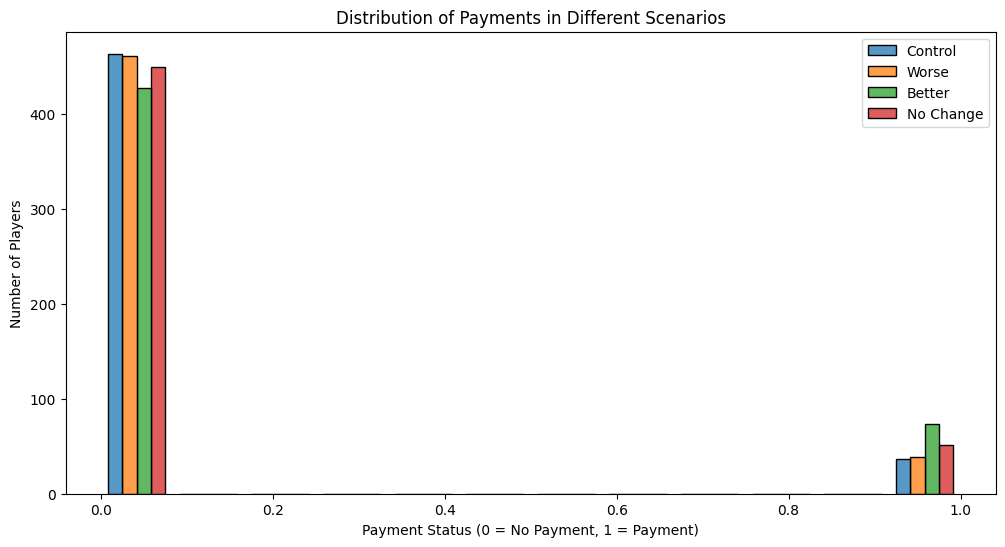

In [24]:
# Генерация данных для визуализации гистограммы
control_data = np.random.binomial(1, 0.10, 500)  # 10% платящих в контрольной группе
worse_data = np.random.binomial(1, 0.09, 500)  # 9% платящих в худшем сценарии
better_data = np.random.binomial(1, 0.12, 500)  # 12% платящих в лучшем сценарии
no_change_data = np.random.binomial(1, 0.10, 500)  # 10% платящих в сценарии без изменений

# Создание DataFrame для удобства визуализации
df = pd.DataFrame({
    "Control": control_data,
    "Worse": worse_data,
    "Better": better_data,
    "No Change": no_change_data
})

# Визуализация гистограммы распределения платежей
plt.figure(figsize=(12, 6))
sns.histplot(df, multiple="dodge", shrink=.8)
plt.title("Distribution of Payments in Different Scenarios")
plt.xlabel("Payment Status (0 = No Payment, 1 = Payment)")
plt.ylabel("Number of Players")
plt.show()


На представленной гистограмме вы можете видеть распределение платежей в разных сценариях:  

Контрольная группа  
Худший сценарий  
Лучший сценарий  
Без изменений  
Каждый столбец показывает количество игроков, которые совершили платежи (1) и не совершили (0) в соответствующем сценарии.  

Теперь перейдем к визуализации доверительных интервалов для демонстрации различий в платежных процентах между группами. Это даст нам более четкое представление о статистической значимости результатов.

**Диаграмма доверительных интервалов:**

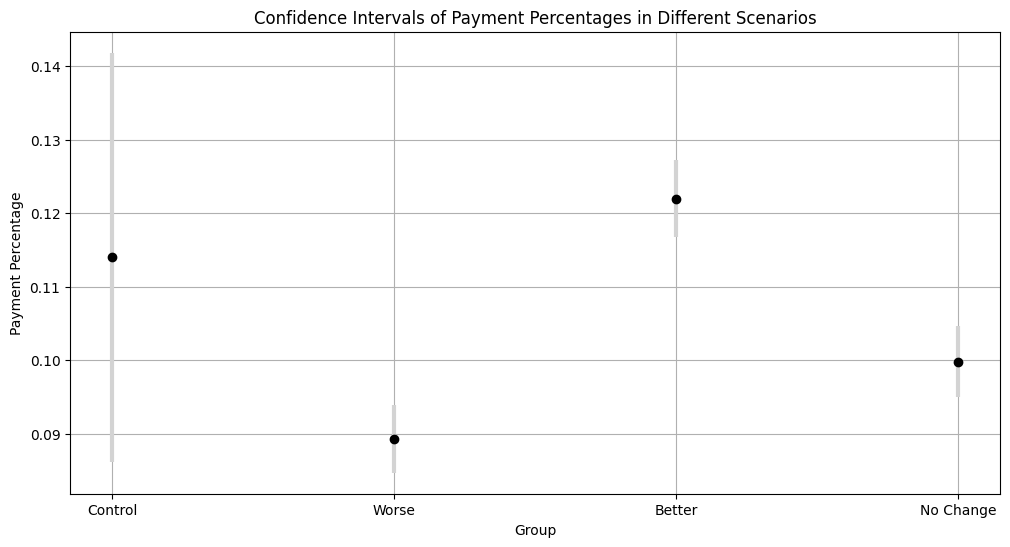

In [25]:
# Данные для визуализации доверительных интервалов
ci_data = {
    "Group": ["Control", "Worse", "Better", "No Change"],
    "Mean": [
        control_group_results["Paying Percentage"],
        scenario_results["Worse Scenario"]["Paying Percentage"],
        scenario_results["Better Scenario"]["Paying Percentage"],
        scenario_results["No Change Scenario"]["Paying Percentage"]
    ],
    "CI Lower": [
        control_group_results["95% CI Lower Bound"],
        scenario_results["Worse Scenario"]["95% CI Lower Bound"],
        scenario_results["Better Scenario"]["95% CI Lower Bound"],
        scenario_results["No Change Scenario"]["95% CI Lower Bound"]
    ],
    "CI Upper": [
        control_group_results["95% CI Upper Bound"],
        scenario_results["Worse Scenario"]["95% CI Upper Bound"],
        scenario_results["Better Scenario"]["95% CI Upper Bound"],
        scenario_results["No Change Scenario"]["95% CI Upper Bound"]
    ]
}

ci_df = pd.DataFrame(ci_data)

# Визуализация доверительных интервалов
plt.figure(figsize=(12, 6))
plt.errorbar(ci_df["Group"], ci_df["Mean"],
             yerr=[ci_df["Mean"] - ci_df["CI Lower"], ci_df["CI Upper"] - ci_df["Mean"]],
             fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
plt.title("Confidence Intervals of Payment Percentages in Different Scenarios")
plt.xlabel("Group")
plt.ylabel("Payment Percentage")
plt.grid(True)
plt.show()


На представленной диаграмме показаны доверительные интервалы процента платящих игроков для различных сценариев:  

Контрольная группа  
Худший сценарий  
Лучший сценарий  
Без изменений  
Каждая точка на диаграмме представляет средний процент платящих игроков в соответствующей группе, а линии показывают 95% доверительные интервалы.  

Эта визуализация помогает наглядно увидеть степень перекрытия между группами и дает представление о статистической значимости различий между ними.  


### **2.11 Заключение**

В целом, результаты эксперимента и соответствующего анализа показывают, что обновление игры не привело к статистически значимому изменению в проценте платящих игроков. Хотя в лучшем сценарии наблюдалось некоторое увеличение, оно оказалось недостаточным для достижения цели в 11%. Эти выводы могут быть полезны для геймдизайнеров при принятии решений о дальнейших изменениях в игре.

> <table style="width:100%">
  <tr style="background-color: white; color: #a34698;">
    <td><b><font size="4">Спасибо за внимание!</font></b></td>
  </tr>
</table>

</div>
<!--END_SECTION:waka-->

<img src="https://raw.githubusercontent.com/trinib/trinib/82213791fa9ff58d3ca768ddd6de2489ec23ffca/images/footer.svg" width="100%">